# Project: Identify Customer Segments

In this project, you will apply unsupervised learning techniques to identify segments of the population that form the core customer base for a mail-order sales company in Germany. These segments can then be used to direct marketing campaigns towards audiences that will have the highest expected rate of returns. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

This notebook will help you complete this task by providing a framework within which you will perform your analysis steps. In each step of the project, you will see some text describing the subtask that you will perform, followed by one or more code cells for you to complete your work. **Feel free to add additional code and markdown cells as you go along so that you can explore everything in precise chunks.** The code cells provided in the base template will outline only the major tasks, and will usually not be enough to cover all of the minor tasks that comprise it.

It should be noted that while there will be precise guidelines on how you should handle certain tasks in the project, there will also be places where an exact specification is not provided. **There will be times in the project where you will need to make and justify your own decisions on how to treat the data.** These are places where there may not be only one way to handle the data. In real-life tasks, there may be many valid ways to approach an analysis task. One of the most important things you can do is clearly document your approach so that other scientists can understand the decisions you've made.

At the end of most sections, there will be a Markdown cell labeled **Discussion**. In these cells, you will report your findings for the completed section, as well as document the decisions that you made in your approach to each subtask. **Your project will be evaluated not just on the code used to complete the tasks outlined, but also your communication about your observations and conclusions at each stage.**

In [1]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# magic word for producing visualizations in notebook
%matplotlib inline

### Step 0: Load the Data

There are four files associated with this project (not including this one):

- `Udacity_AZDIAS_Subset.csv`: Demographics data for the general population of Germany; 891211 persons (rows) x 85 features (columns).
- `Udacity_CUSTOMERS_Subset.csv`: Demographics data for customers of a mail-order company; 191652 persons (rows) x 85 features (columns).
- `Data_Dictionary.md`: Detailed information file about the features in the provided datasets.
- `AZDIAS_Feature_Summary.csv`: Summary of feature attributes for demographics data; 85 features (rows) x 4 columns

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. You will use this information to cluster the general population into groups with similar demographic properties. Then, you will see how the people in the customers dataset fit into those created clusters. The hope here is that certain clusters are over-represented in the customers data, as compared to the general population; those over-represented clusters will be assumed to be part of the core userbase. This information can then be used for further applications, such as targeting for a marketing campaign.

To start off with, load in the demographics data for the general population into a pandas DataFrame, and do the same for the feature attributes summary. Note for all of the `.csv` data files in this project: they're semicolon (`;`) delimited, so you'll need an additional argument in your [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call to read in the data properly. Also, considering the size of the main dataset, it may take some time for it to load completely.

Once the dataset is loaded, it's recommended that you take a little bit of time just browsing the general structure of the dataset and feature summary file. You'll be getting deep into the innards of the cleaning in the first major step of the project, so gaining some general familiarity can help you get your bearings.

In [2]:
# Load in the general demographics data.
azdias =  pd.read_csv('Data/P3/Udacity_AZDIAS_Subset.csv', delimiter=';')

# Load in the feature summary file.
feat_info = pd.read_csv('Data/P3/AZDIAS_Feature_Summary.csv', delimiter=';')

In [3]:
# Check the structure of the data after it's loaded (e.g. print the number of
# rows and columns, print the first few rows).

azdias.head()

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,-1,2,1,2.0,3,4,3,5,5,3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,-1,1,2,5.0,1,5,2,5,4,5,...,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,-1,3,2,3.0,1,4,1,2,3,5,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
3,2,4,2,2.0,4,2,5,2,1,2,...,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
4,-1,3,1,5.0,4,3,4,1,3,2,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0


In [4]:
azdias.shape

(891221, 85)

In [5]:
feat_info.head()

,attribute,information_level,type,missing_or_unknown
0,AGER_TYP,person,categorical,"[-1,0]"
1,ALTERSKATEGORIE_GROB,person,ordinal,"[-1,0,9]"
2,ANREDE_KZ,person,categorical,"[-1,0]"
3,CJT_GESAMTTYP,person,categorical,[0]
4,FINANZ_MINIMALIST,person,ordinal,[-1]


> **Tip**: Add additional cells to keep everything in reasonably-sized chunks! Keyboard shortcut `esc --> a` (press escape to enter command mode, then press the 'A' key) adds a new cell before the active cell, and `esc --> b` adds a new cell after the active cell. If you need to convert an active cell to a markdown cell, use `esc --> m` and to convert to a code cell, use `esc --> y`. 

## Step 1: Preprocessing

### Step 1.1: Assess Missing Data

The feature summary file contains a summary of properties for each demographics data column. You will use this file to help you make cleaning decisions during this stage of the project. First of all, you should assess the demographics data in terms of missing data. Pay attention to the following points as you perform your analysis, and take notes on what you observe. Make sure that you fill in the **Discussion** cell with your findings and decisions at the end of each step that has one!

#### Step 1.1.1: Convert Missing Value Codes to NaNs
The fourth column of the feature attributes summary (loaded in above as `feat_info`) documents the codes from the data dictionary that indicate missing or unknown data. While the file encodes this as a list (e.g. `[-1,0]`), this will get read in as a string object. You'll need to do a little bit of parsing to make use of it to identify and clean the data. Convert data that matches a 'missing' or 'unknown' value code into a numpy NaN value. You might want to see how much data takes on a 'missing' or 'unknown' code, and how much data is naturally missing, as a point of interest.

**As one more reminder, you are encouraged to add additional cells to break up your analysis into manageable chunks.**

In [6]:
# Proportion of naturally missing datapooints by feature
(azdias.isnull().sum()/len(azdias))*100

AGER_TYP                  0.000000
ALTERSKATEGORIE_GROB      0.000000
ANREDE_KZ                 0.000000
CJT_GESAMTTYP             0.544646
FINANZ_MINIMALIST         0.000000
FINANZ_SPARER             0.000000
FINANZ_VORSORGER          0.000000
FINANZ_ANLEGER            0.000000
FINANZ_UNAUFFAELLIGER     0.000000
FINANZ_HAUSBAUER          0.000000
FINANZTYP                 0.000000
GEBURTSJAHR               0.000000
GFK_URLAUBERTYP           0.544646
GREEN_AVANTGARDE          0.000000
HEALTH_TYP                0.000000
LP_LEBENSPHASE_FEIN       0.544646
LP_LEBENSPHASE_GROB       0.544646
LP_FAMILIE_FEIN           0.544646
LP_FAMILIE_GROB           0.544646
LP_STATUS_FEIN            0.544646
LP_STATUS_GROB            0.544646
NATIONALITAET_KZ          0.000000
PRAEGENDE_JUGENDJAHRE     0.000000
RETOURTYP_BK_S            0.544646
SEMIO_SOZ                 0.000000
SEMIO_FAM                 0.000000
SEMIO_REL                 0.000000
SEMIO_MAT                 0.000000
SEMIO_VERT          

In [7]:
# Total number of values missing
sum(azdias.isnull().sum())

4896838

In [8]:
# Although this feature has no missing values, according to the data_dictionary file 
#-1: unknown
# 0: no classification possible
azdias.AGER_TYP.value_counts()

-1    677503
 2     98472
 1     79802
 3     27104
 0      8340
Name: AGER_TYP, dtype: int64

In [9]:
feat_info.columns

Index(['attribute', 'information_level', 'type', 'missing_or_unknown'], dtype='object')

In [10]:
# Identify missing or unknown data values and convert them to NaNs.

# Lets convert the list into a string we can split via str.split
feat_info.missing_or_unknown = feat_info.missing_or_unknown.str.replace('[', '')
feat_info.missing_or_unknown = feat_info.missing_or_unknown.str.replace(']', '')
feat_info.missing_or_unknown = feat_info.missing_or_unknown.str.split(',')

In [11]:
from pandas.api.types import is_numeric_dtype
for col, value in zip(feat_info.attribute, feat_info.missing_or_unknown):
    if value[0] !='':
        for val in value:
            if val not in ['X', 'XX']:
                val = int(val)
#             if is_numeric_dtype(val):
                azdias.loc[azdias[col] == val, col] = np.nan

In [12]:
azdias.head()

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,NaN,2.0,1.0,2.0,3.0,4.0,3.0,5.0,5.0,3.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,1.0,2.0,5.0,1.0,5.0,2.0,5.0,4.0,5.0,...,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,NaN,3.0,2.0,3.0,1.0,4.0,1.0,2.0,3.0,5.0,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
3,2.0,4.0,2.0,2.0,4.0,2.0,5.0,2.0,1.0,2.0,...,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
4,NaN,3.0,1.0,5.0,4.0,3.0,4.0,1.0,3.0,2.0,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0


#### Step 1.1.2: Assess Missing Data in Each Column

How much missing data is present in each column? There are a few columns that are outliers in terms of the proportion of values that are missing. You will want to use matplotlib's [`hist()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.hist.html) function to visualize the distribution of missing value counts to find these columns. Identify and document these columns. While some of these columns might have justifications for keeping or re-encoding the data, for this project you should just remove them from the dataframe. (Feel free to make remarks about these outlier columns in the discussion, however!)

For the remaining features, are there any patterns in which columns have, or share, missing data?

In [13]:
# Perform an assessment of how much missing data there is in each column of the
# dataset.
null_col = azdias.isnull().sum().sort_values(ascending=False).to_frame(name='value')
null_col

,value
TITEL_KZ,889061
AGER_TYP,685843
KK_KUNDENTYP,584612
KBA05_BAUMAX,476524
GEBURTSJAHR,392318
ALTER_HH,310267
REGIOTYP,158064
KKK,158064
W_KEIT_KIND_HH,147988
KBA05_ANTG4,133324


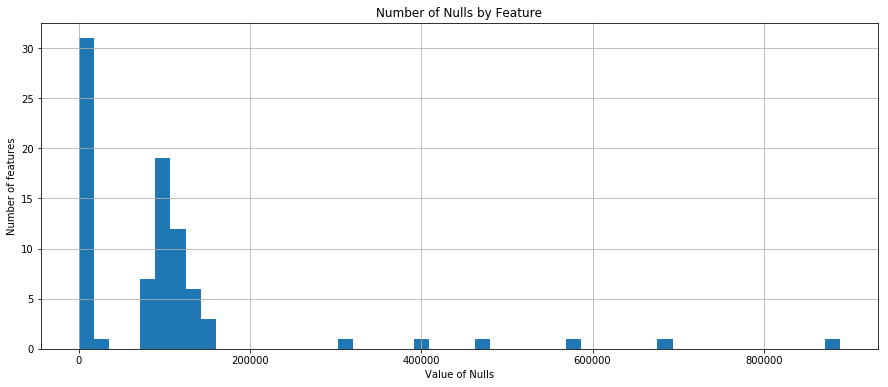

In [14]:
null_col.hist(bins=50, figsize=(15,6))
plt.xlabel("Value of Nulls")
plt.ylabel('Number of features')
plt.title('Number of Nulls by Feature')
plt.show()

In [15]:
# Investigate patterns in the amount of missing data in each column.
azdias.isnull().sum().describe()

count        85.000000
mean      98503.647059
std      146604.143775
min           0.000000
25%           0.000000
50%       93148.000000
75%      116515.000000
max      889061.000000
dtype: float64

In [16]:
null_outliers = null_col.head(6)
null_outliers

,value
TITEL_KZ,889061
AGER_TYP,685843
KK_KUNDENTYP,584612
KBA05_BAUMAX,476524
GEBURTSJAHR,392318
ALTER_HH,310267


In [17]:
null_outliers.sum()

value    3338625
dtype: int64

In [18]:
# List to be dropped from data set due to high number of outliers
list(null_outliers.index)

['TITEL_KZ',
 'AGER_TYP',
 'KK_KUNDENTYP',
 'KBA05_BAUMAX',
 'GEBURTSJAHR',
 'ALTER_HH']

In [19]:
len(azdias.columns)

85

In [20]:
# Remove the outlier columns from the dataset. (You'll perform other data
# engineering tasks such as re-encoding and imputation later.)
azdias_col_clean = azdias.drop(list(null_outliers.index), axis=1)
len(azdias_col_clean.columns)

79

In [21]:
null_col.head(30)

,value
TITEL_KZ,889061
AGER_TYP,685843
KK_KUNDENTYP,584612
KBA05_BAUMAX,476524
GEBURTSJAHR,392318
ALTER_HH,310267
REGIOTYP,158064
KKK,158064
W_KEIT_KIND_HH,147988
KBA05_ANTG4,133324


#### Discussion 1.1.2: Assess Missing Data in Each Column

The Azdias dataset includes 891,221 observationa with 85 features. Out of these features there are 6 with more than 200,000 null values as listed below:

- TITEL_KZ: 889,061
- AGER_TYP: 685,843
- KK_KUNDENTYP: 584,612
- KBA05_BAUMAX: 476,524
- GEBURTSJAHR: 392,318
- ALTER_HH: 310,267

I don't believe these features are missing data because of a human error or because the data is not available but because simply because of the nature of the feature. For example if we have data on a population car ownership and if a feature "Owns Ferrari" is full of nulls, doesn't mean the observations are wrong or feature is useless but due to nature of this feature you would expect it to be empty.

Same applies to "TITEL_KZ" which in accordance to the data dictionary is an academic title flag and PHD holders like Ferrari owners are not very common when taking the entire population of any country.

Also, something interesting is that some features visible in the histogram has the same exact number of missing observations, here is a list: 

- KBA05_ANTG4: 133,324
- KBA05_GBZ: 133,324
- MOBI_REGIO: 133,324
- KBA05_ANTG1: 133,324
- KBA05_ANTG2: 133,324
- KBA05_ANTG3: 133,324

- PLZ8_GBZ: 116,515
- PLZ8_HHZ: 116,515
- PLZ8_BAUMAX: 116,515
- PLZ8_ANTG4: 116,515
- PLZ8_ANTG1: 116,515
- PLZ8_ANTG3: 116,515
- PLZ8_ANTG2: 116,515

- SHOPPER_TYP: 111,196
- VERS_TYP: 111,196
- HEALTH_TYP: 111,196

Going to the data dictionary and looking at the feature names, they seem very similar features. For example the first set above is related to home ownership but different scales which looks like a dummy variables created when data was extracted which again makes the missing observations natural due to the fact that the observations are spread among 6 or more features.

The 6 columns that will be dropped from the dataset are : 

'TITEL_KZ',
'AGER_TYP',
'KK_KUNDENTYP',
'KBA05_BAUMAX',
'GEBURTSJAHR',
'ALTER_HH'



#### Step 1.1.3: Assess Missing Data in Each Row

Now, you'll perform a similar assessment for the rows of the dataset. How much data is missing in each row? As with the columns, you should see some groups of points that have a very different numbers of missing values. Divide the data into two subsets: one for data points that are above some threshold for missing values, and a second subset for points below that threshold.

In order to know what to do with the outlier rows, we should see if the distribution of data values on columns that are not missing data (or are missing very little data) are similar or different between the two groups. Select at least five of these columns and compare the distribution of values.
- You can use seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) function to create a bar chart of code frequencies and matplotlib's [`subplot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.subplot.html) function to put bar charts for the two subplots side by side.
- To reduce repeated code, you might want to write a function that can perform this comparison, taking as one of its arguments a column to be compared.

Depending on what you observe in your comparison, this will have implications on how you approach your conclusions later in the analysis. If the distributions of non-missing features look similar between the data with many missing values and the data with few or no missing values, then we could argue that simply dropping those points from the analysis won't present a major issue. On the other hand, if the data with many missing values looks very different from the data with few or no missing values, then we should make a note on those data as special. We'll revisit these data later on. **Either way, you should continue your analysis for now using just the subset of the data with few or no missing values.**

In [22]:
azdias.shape

(891221, 85)

In [23]:
# How much data is missing in each row of the dataset?
null_rows = azdias.isnull().sum(axis=1).sort_values(ascending=False).to_frame('value')

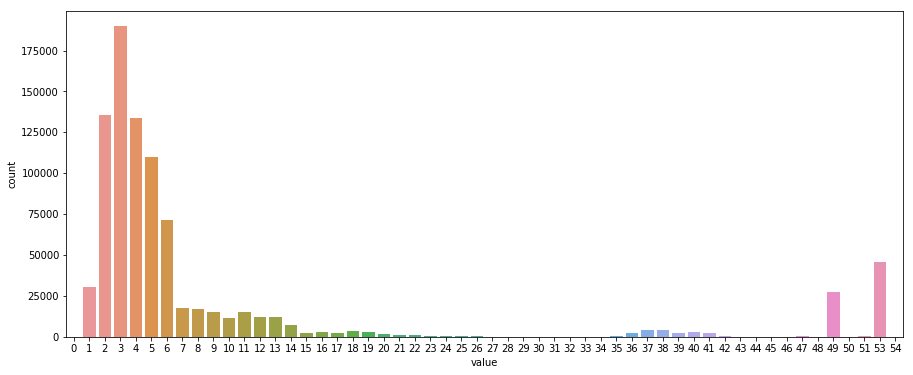

In [24]:
fig = plt.figure(figsize=(15,6))
sns.countplot(null_rows.value)

In [25]:
# Write code to divide the data into two subsets based on the number of missing
# values in each row.

# First sub-set with 27 or more columns in null values
high_nulls = azdias_col_clean[azdias_col_clean.isnull().sum(axis=1)>= 27]

# Second sub-set with less than 27 columns in null values
low_nulls = azdias_col_clean[azdias_col_clean.isnull().sum(axis=1)< 27]

In [26]:
len(azdias), len(high_nulls), len(low_nulls), 

(891221, 93200, 798021)

In [27]:
high_nulls.shape, low_nulls.shape

((93200, 79), (798021, 79))

In [28]:
# List of columns with zero null values
high_nulls.isnull().sum().sort_values().head(6)

ZABEOTYP      0
SEMIO_REL     0
SEMIO_MAT     0
SEMIO_VERT    0
SEMIO_LUST    0
SEMIO_ERL     0
dtype: int64

In [29]:
# Get list of columns where both the low and high null subsets have zero null observations 
columns = []
for i in azdias_col_clean:
    if (low_nulls[i].isnull().sum() == 0) & (high_nulls[i].isnull().sum() == 0):
        columns.append(i)

In [30]:
columns

['ANREDE_KZ',
 'FINANZ_MINIMALIST',
 'FINANZ_SPARER',
 'FINANZ_VORSORGER',
 'FINANZ_ANLEGER',
 'FINANZ_UNAUFFAELLIGER',
 'FINANZ_HAUSBAUER',
 'FINANZTYP',
 'GREEN_AVANTGARDE',
 'SEMIO_SOZ',
 'SEMIO_FAM',
 'SEMIO_REL',
 'SEMIO_MAT',
 'SEMIO_VERT',
 'SEMIO_LUST',
 'SEMIO_ERL',
 'SEMIO_KULT',
 'SEMIO_RAT',
 'SEMIO_KRIT',
 'SEMIO_DOM',
 'SEMIO_KAEM',
 'SEMIO_PFLICHT',
 'SEMIO_TRADV',
 'ZABEOTYP']

In [31]:
def count_plot(df_1, df_2, col_list):
    plt.figure(figsize=(15,20), facecolor='white')
    for col in col_list:
        fig, (ax1, ax2) = plt.subplots(1,2, sharey=True)
        ax1.title.set_text('High Null Subset')
        ax2.title.set_text('Low Null Subset')
        sns.countplot(df_1[col], ax=ax1)
        sns.countplot(df_2[col], ax=ax2)

<Figure size 1080x1440 with 0 Axes>

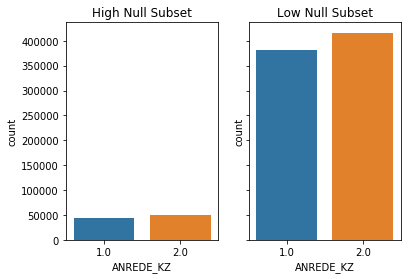

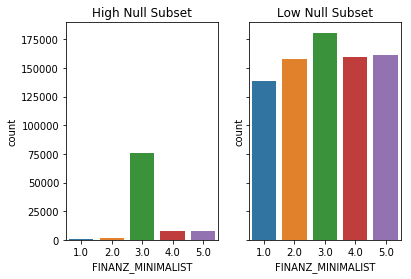

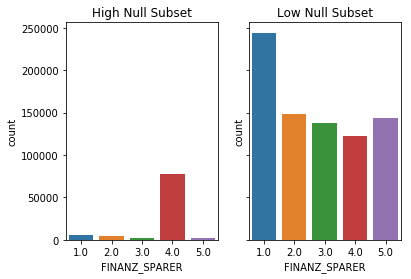

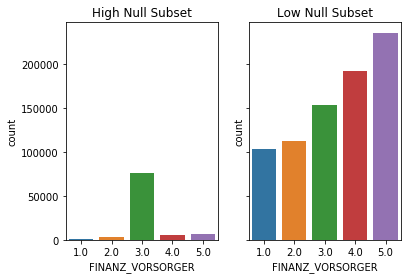

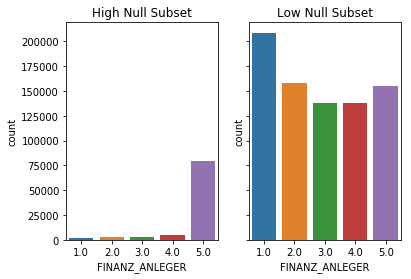

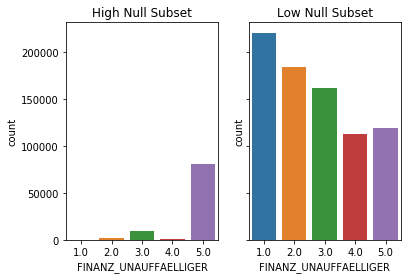

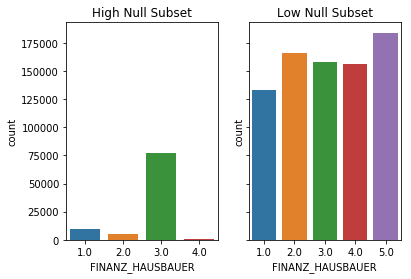

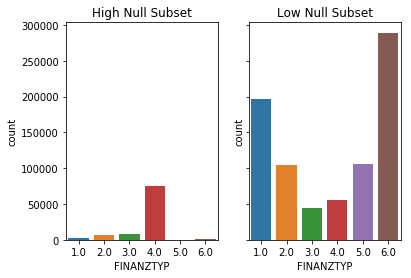

In [32]:
# Choose 8 columns from the list of non-null columns
count_plot(high_nulls, low_nulls, columns[:8])

#### Discussion 1.1.3: Assess Missing Data in Each Row

Looking at the above 8 variables with no missing data, we can see that only the "ANREDE_KZ" variable has a similar distribution between both dataset as for the rest of the variables, the difference is huge in the distribution with one factor always showing as an outlier which makes dropping these observations very risky causing the loss of valuable data. 

Then when looking at these variables seperatly: 'FINANZ_MINIMALIST', 'FINANZ_SPARER', 'FINANZ_VORSORGER', 'FINANZ_ANLEGER', 'FINANZ_UNAUFFAELLIGER', 'FINANZ_HAUSBAUER', 'FINANZTYP', I noticed that they are all dummy varibales of the variable "FINANZTYP" which gives us an idea about how the data was prepared, maybe this issue will be solved when doing PCA but for now. 

Lets explore coupld of 4 more variables before deciding if dropping these observations with high nulls makes sense.

<Figure size 1080x1440 with 0 Axes>

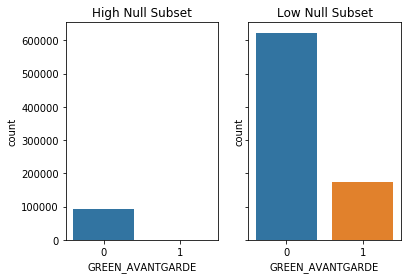

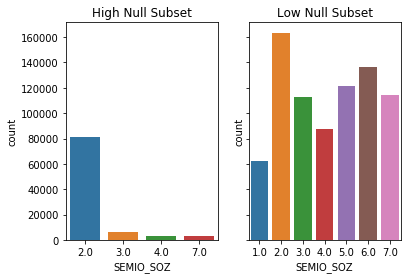

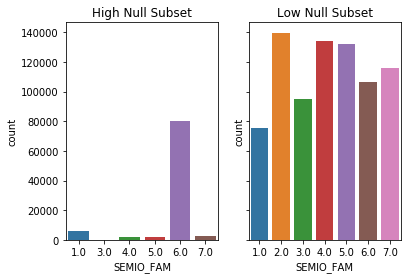

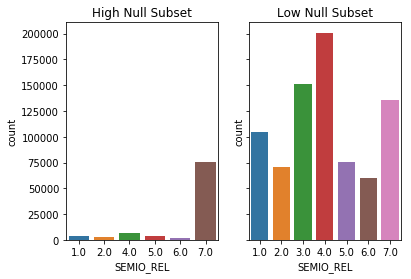

In [33]:
# Choose 4 more columns
count_plot(high_nulls, low_nulls, columns[8:12])

Same issue as above, we have a similar distribution on "GREEN_AVANTGARDE" then the rest since they are dummy variables, we can see a difference in the distribution between the 2 datasets with one factor always showing more than the rest.

I don't think dropping these observations is a good idea because the data missing on these observations might be naturally unavailable and removing them will skew the dataset.

For example it will be as if a university decides to combine all computer science courses in one dataset having the course name as columns and students as rows and filling null if a student didn’t take a course, which will normally cause the undergraduate courses to have little to no nulls in say CSC101 and high nulls on an advanced AI PHD course. 

Then looking at the data I decide to remove all observations with high nulls causing me to skew data for students, keeping young undergraduates and automatically dropping the graduates and PHD students. Then when I run my model to predict the number of students I can get for an advanced CS course, it will show that this course will fail because the model I built in the first place was skewed and bias. This is a typical data leakage problem lots of datasets suffer from.


### Step 1.2: Select and Re-Encode Features

Checking for missing data isn't the only way in which you can prepare a dataset for analysis. Since the unsupervised learning techniques to be used will only work on data that is encoded numerically, you need to make a few encoding changes or additional assumptions to be able to make progress. In addition, while almost all of the values in the dataset are encoded using numbers, not all of them represent numeric values. Check the third column of the feature summary (`feat_info`) for a summary of types of measurement.
- For numeric and interval data, these features can be kept without changes.
- Most of the variables in the dataset are ordinal in nature. While ordinal values may technically be non-linear in spacing, make the simplifying assumption that the ordinal variables can be treated as being interval in nature (that is, kept without any changes).
- Special handling may be necessary for the remaining two variable types: categorical, and 'mixed'.

In the first two parts of this sub-step, you will perform an investigation of the categorical and mixed-type features and make a decision on each of them, whether you will keep, drop, or re-encode each. Then, in the last part, you will create a new data frame with only the selected and engineered columns.

Data wrangling is often the trickiest part of the data analysis process, and there's a lot of it to be done here. But stick with it: once you're done with this step, you'll be ready to get to the machine learning parts of the project!

In [34]:
# How many features are there of each data type?

feat_info.type.value_counts()

ordinal        49
categorical    21
numeric         7
mixed           7
interval        1
Name: type, dtype: int64

#### Step 1.2.1: Re-Encode Categorical Features

For categorical data, you would ordinarily need to encode the levels as dummy variables. Depending on the number of categories, perform one of the following:
- For binary (two-level) categoricals that take numeric values, you can keep them without needing to do anything.
- There is one binary variable that takes on non-numeric values. For this one, you need to re-encode the values as numbers or create a dummy variable.
- For multi-level categoricals (three or more values), you can choose to encode the values using multiple dummy variables (e.g. via [OneHotEncoder](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html)), or (to keep things straightforward) just drop them from the analysis. As always, document your choices in the Discussion section.

### Classifiying the categorical variables

In [35]:
# Assess categorical variables: which are binary, which are multi-level, and
# which one needs to be re-encoded?

# This is the list of categorical variables
cat_features = list(feat_info[feat_info.type == 'categorical'].attribute)

multi_feat = []

for feat in cat_features:
    if len(azdias[feat].value_counts()) > 2:
        multi_feat.append(feat)

# This is a list of categorical features with more than 2 levels that will need to be re-encoded
multi_feat

['AGER_TYP',
 'CJT_GESAMTTYP',
 'FINANZTYP',
 'GFK_URLAUBERTYP',
 'LP_FAMILIE_FEIN',
 'LP_FAMILIE_GROB',
 'LP_STATUS_FEIN',
 'LP_STATUS_GROB',
 'NATIONALITAET_KZ',
 'SHOPPER_TYP',
 'TITEL_KZ',
 'ZABEOTYP',
 'KK_KUNDENTYP',
 'GEBAEUDETYP',
 'CAMEO_DEUG_2015',
 'CAMEO_DEU_2015']

In [36]:
binary_numeric_feat = []

for feat in cat_features:
    if (len(azdias[feat].value_counts()) == 2) and (azdias[feat].dtype != 'object'):
        binary_numeric_feat.append(feat)

# This is a list of binary numeric variables that I wont need to re-encode
binary_numeric_feat

['ANREDE_KZ', 'GREEN_AVANTGARDE', 'SOHO_KZ', 'VERS_TYP']

In [37]:
obj_feat = []
for feat in cat_features:
    if azdias[feat].dtype == 'object':
        obj_feat.append(feat)
        
# These are the categorical varibales that include at least one non-numeric levels
obj_feat

['OST_WEST_KZ', 'CAMEO_DEUG_2015', 'CAMEO_DEU_2015']

In [38]:
# This is the binary feature with non-numeric values
binary_feat = []

for feat in cat_features:
    if azdias[feat].dtype == 'object' and len(azdias[feat].value_counts()) == 2:
        binary_feat.append(feat)
        
# This is the binary variable with non-numeric levels         
binary_feat
for i in binary_feat:
    print(azdias[i].value_counts())

W    629528
O    168545
Name: OST_WEST_KZ, dtype: int64


### Re-encoding the variables as instructed 

In [39]:
# Re-encoding the binary variable with non-numeric values
low_nulls.OST_WEST_KZ = low_nulls.OST_WEST_KZ.map({'W':0, 'O':1})
low_nulls.OST_WEST_KZ.value_counts()

C:\Users\wfahme\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\generic.py:4401: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


0    629484
1    168537
Name: OST_WEST_KZ, dtype: int64

In [40]:
# Keep on;y the columns available in low_nulls dataset we extracted after the row cleaning activity
hot_encode = []
for i in low_nulls.columns:
    if i in multi_feat:
        hot_encode.append(i)
hot_encode

['CJT_GESAMTTYP',
 'FINANZTYP',
 'GFK_URLAUBERTYP',
 'LP_FAMILIE_FEIN',
 'LP_FAMILIE_GROB',
 'LP_STATUS_FEIN',
 'LP_STATUS_GROB',
 'NATIONALITAET_KZ',
 'SHOPPER_TYP',
 'ZABEOTYP',
 'GEBAEUDETYP',
 'CAMEO_DEUG_2015',
 'CAMEO_DEU_2015']

In [41]:
# Re-encoding the multilevel categorical variables to dummy variables using pd.get_dummies() function
encoded = pd.concat([pd.get_dummies(low_nulls[col], prefix=col) for col in hot_encode], axis=1)
low_nulls.drop(hot_encode, axis=1, inplace=True)

C:\Users\wfahme\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\frame.py:3694: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


In [42]:
# This is a clean dataframe that has all the value numeric, encoded and low on null without the columns of high nulls
azdias_new = pd.concat([low_nulls, encoded], axis=1)

In [43]:
# Context manager to temporarily set options in the with statement context
def display_all(df):
    with pd.option_context('display.max_rows', 1000, 'display.max_columns', 1000):
        display(df)

In [44]:
display_all(azdias_new.head(3))

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,LP_LEBENSPHASE_FEIN,LP_LEBENSPHASE_GROB,PRAEGENDE_JUGENDJAHRE,RETOURTYP_BK_S,SEMIO_SOZ,SEMIO_FAM,SEMIO_REL,SEMIO_MAT,SEMIO_VERT,SEMIO_LUST,SEMIO_ERL,SEMIO_KULT,SEMIO_RAT,SEMIO_KRIT,SEMIO_DOM,SEMIO_KAEM,SEMIO_PFLICHT,SEMIO_TRADV,SOHO_KZ,VERS_TYP,ANZ_PERSONEN,ANZ_TITEL,HH_EINKOMMEN_SCORE,W_KEIT_KIND_HH,WOHNDAUER_2008,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,KONSUMNAEHE,MIN_GEBAEUDEJAHR,OST_WEST_KZ,WOHNLAGE,CAMEO_INTL_2015,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_GBZ,BALLRAUM,EWDICHTE,INNENSTADT,GEBAEUDETYP_RASTER,KKK,MOBI_REGIO,ONLINE_AFFINITAET,REGIOTYP,KBA13_ANZAHL_PKW,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB,CJT_GESAMTTYP_1.0,CJT_GESAMTTYP_2.0,CJT_GESAMTTYP_3.0,CJT_GESAMTTYP_4.0,CJT_GESAMTTYP_5.0,CJT_GESAMTTYP_6.0,FINANZTYP_1.0,FINANZTYP_2.0,FINANZTYP_3.0,FINANZTYP_4.0,FINANZTYP_5.0,FINANZTYP_6.0,GFK_URLAUBERTYP_1.0,GFK_URLAUBERTYP_2.0,GFK_URLAUBERTYP_3.0,GFK_URLAUBERTYP_4.0,GFK_URLAUBERTYP_5.0,GFK_URLAUBERTYP_6.0,GFK_URLAUBERTYP_7.0,GFK_URLAUBERTYP_8.0,GFK_URLAUBERTYP_9.0,GFK_URLAUBERTYP_10.0,GFK_URLAUBERTYP_11.0,GFK_URLAUBERTYP_12.0,LP_FAMILIE_FEIN_1.0,LP_FAMILIE_FEIN_2.0,LP_FAMILIE_FEIN_3.0,LP_FAMILIE_FEIN_4.0,LP_FAMILIE_FEIN_5.0,LP_FAMILIE_FEIN_6.0,LP_FAMILIE_FEIN_7.0,LP_FAMILIE_FEIN_8.0,LP_FAMILIE_FEIN_9.0,LP_FAMILIE_FEIN_10.0,LP_FAMILIE_FEIN_11.0,LP_FAMILIE_GROB_1.0,LP_FAMILIE_GROB_2.0,LP_FAMILIE_GROB_3.0,LP_FAMILIE_GROB_4.0,LP_FAMILIE_GROB_5.0,LP_STATUS_FEIN_1.0,LP_STATUS_FEIN_2.0,LP_STATUS_FEIN_3.0,LP_STATUS_FEIN_4.0,LP_STATUS_FEIN_5.0,LP_STATUS_FEIN_6.0,LP_STATUS_FEIN_7.0,LP_STATUS_FEIN_8.0,LP_STATUS_FEIN_9.0,LP_STATUS_FEIN_10.0,LP_STATUS_GROB_1.0,LP_STATUS_GROB_2.0,LP_STATUS_GROB_3.0,LP_STATUS_GROB_4.0,LP_STATUS_GROB_5.0,NATIONALITAET_KZ_1.0,NATIONALITAET_KZ_2.0,NATIONALITAET_KZ_3.0,SHOPPER_TYP_0.0,SHOPPER_TYP_1.0,SHOPPER_TYP_2.0,SHOPPER_TYP_3.0,ZABEOTYP_1.0,ZABEOTYP_2.0,ZABEOTYP_3.0,ZABEOTYP_4.0,ZABEOTYP_5.0,ZABEOTYP_6.0,GEBAEUDETYP_1.0,GEBAEUDETYP_2.0,GEBAEUDETYP_3.0,GEBAEUDETYP_4.0,GEBAEUDETYP_5.0,GEBAEUDETYP_6.0,GEBAEUDETYP_8.0,CAMEO_DEUG_2015_1,CAMEO_DEUG_2015_2,CAMEO_DEUG_2015_3,CAMEO_DEUG_2015_4,CAMEO_DEUG_2015_5,CAMEO_DEUG_2015_6,CAMEO_DEUG_2015_7,CAMEO_DEUG_2015_8,CAMEO_DEUG_2015_9,CAMEO_DEUG_2015_X,CAMEO_DEU_2015_1A,CAMEO_DEU_2015_1B,CAMEO_DEU_2015_1C,CAMEO_DEU_2015_1D,CAMEO_DEU_2015_1E,CAMEO_DEU_2015_2A,CAMEO_DEU_2015_2B,CAMEO_DEU_2015_2C,CAMEO_DEU_2015_2D,CAMEO_DEU_2015_3A,CAMEO_DEU_2015_3B,CAMEO_DEU_2015_3C,CAMEO_DEU_2015_3D,CAMEO_DEU_2015_4A,CAMEO_DEU_2015_4B,CAMEO_DEU_2015_4C,CAMEO_DEU_2015_4D,CAMEO_DEU_2015_4E,CAMEO_DEU_2015_5A,CAMEO_DEU_2015_5B,CAMEO_DEU_2015_5C,CAMEO_DEU_2015_5D,CAMEO_DEU_2015_5E,CAMEO_DEU_2015_5F,CAMEO_DEU_2015_6A,CAMEO_DEU_2015_6B,CAMEO_DEU_2015_6C,CAMEO_DEU_2015_6D,CAMEO_DEU_2015_6E,CAMEO_DEU_2015_6F,CAMEO_DEU_2015_7A,CAMEO_DEU_2015_7B,CAMEO_DEU_2015_7C,CAMEO_DEU_2015_7D,CAMEO_DEU_2015_7E,CAMEO_DEU_2015_8A,CAMEO_DEU_2015_8B,CAMEO_DEU_2015_8C,CAMEO_DEU_2015_8D,CAMEO_DEU_2015_9A,CAMEO_DEU_2015_9B,CAMEO_DEU_2015_9C,CAMEO_DEU_2015_9D,CAMEO_DEU_2015_9E,CAMEO_DEU_2015_XX
1,1.0,2.0,1.0,5.0,2.0,5.0,4.0,5.0,0,3.0,21.0,6.0,14.0,1.0,5.0,4.0,4.0,3.0,1.0,2.0,2.0,3.0,6.0,4.0,7.0,4.0,7.0,6.0,1.0,2.0,2.0,0.0,6.0,3.0,9.0,11.0,0.0,1.0,1992.0,0,4.0,51,0.0,0.0,0.0,2.0,1.0,6.0,3.0,8.0,3.0,2.0,1.0,3.0,3.0,963.0,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
2,3.0,2.0,1.0,4.0,1.0,2.0,3.0,5.0,1,3.0,3.0,1.0,15.0,3.0,4.0,1.0,3.0,3.0,4.0,4.0,6.0,3.0,4.0,7.0,7.0,7.0,3.0,3.0,0.0,1.0,1.0,0.0,4.0,3.0,9.0,10.0,0.0,5.0,1992.0,0,2.0,24,1.0,3.0,1.0,0.0,3.0,2.0,4.0,4.0,4.0,2.0,3.0,2.0,2.0,712.0,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0,0,0,1,0

In [45]:
len(hot_encode), len(obj_feat), len(binary_feat), len(binary_numeric_feat)

(13, 3, 1, 4)

#### Discussion 1.2.1: Re-Encode Categorical Features

We have 17 categorical variables available in this dataset which are broken as below:

1. We have 3 numerical binary variables: 'ANREDE_KZ', 'GREEN_AVANTGARDE', 'SOHO_KZ'

2. We have 1 binary variables with non-numeric levels: 'OST_WEST_KZ'

3. We have 13 multi-level variables: 'CJT_GESAMTTYP', 'FINANZTYP', 'GFK_URLAUBERTYP', 'LP_FAMILIE_FEIN', 'LP_FAMILIE_GROB', 'LP_STATUS_FEIN','LP_STATUS_GROB','NATIONALITAET_KZ','SHOPPER_TYP','ZABEOTYP','GEBAEUDETYP','CAMEO_DEUG_2015','CAMEO_DEU_2015'

#### Actions taken:

1. For the 3 numeric binary variables nothing will be done.
2. For the 1 binary variable, I re-encoded it manually and replaces the 2 levels with 0 and 1 respectively
3. As for the 13 multilevel variables, I wrote a for loop that uses get_dummies function to create a new dummy varibale for every level in the category and dropped the original variable from the dataset

#### Step 1.2.2: Engineer Mixed-Type Features

There are a handful of features that are marked as "mixed" in the feature summary that require special treatment in order to be included in the analysis. There are two in particular that deserve attention; the handling of the rest are up to your own choices:
- "PRAEGENDE_JUGENDJAHRE" combines information on three dimensions: generation by decade, movement (mainstream vs. avantgarde), and nation (east vs. west). While there aren't enough levels to disentangle east from west, you should create two new variables to capture the other two dimensions: an interval-type variable for decade, and a binary variable for movement.
- "CAMEO_INTL_2015" combines information on two axes: wealth and life stage. Break up the two-digit codes by their 'tens'-place and 'ones'-place digits into two new ordinal variables (which, for the purposes of this project, is equivalent to just treating them as their raw numeric values).
- If you decide to keep or engineer new features around the other mixed-type features, make sure you note your steps in the Discussion section.

Be sure to check `Data_Dictionary.md` for the details needed to finish these tasks.

In [46]:
# This is the list of mixed variables
mix_features = list(feat_info[feat_info.type == 'mixed'].attribute)
mix_features

['LP_LEBENSPHASE_FEIN',
 'LP_LEBENSPHASE_GROB',
 'PRAEGENDE_JUGENDJAHRE',
 'WOHNLAGE',
 'CAMEO_INTL_2015',
 'KBA05_BAUMAX',
 'PLZ8_BAUMAX']

In [47]:
# Investigate "PRAEGENDE_JUGENDJAHRE" and engineer two new variables.
azdias.PRAEGENDE_JUGENDJAHRE.value_counts()

14.0    188697
8.0     145988
5.0      86416
10.0     85808
3.0      55195
15.0     42547
11.0     35752
9.0      33570
6.0      25652
12.0     24446
1.0      21282
4.0      20451
2.0       7479
13.0      5764
7.0       4010
Name: PRAEGENDE_JUGENDJAHRE, dtype: int64

#### Levels as available in dictionary
- -1: unknown
-  0: unknown
-  1: 40s - war years (Mainstream, E+W)
-  2: 40s - reconstruction years (Avantgarde, E+W)
-  3: 50s - economic miracle (Mainstream, E+W)
-  4: 50s - milk bar / Individualisation (Avantgarde, E+W)
-  5: 60s - economic miracle (Mainstream, E+W)
-  6: 60s - generation 68 / student protestors (Avantgarde, W)
-  7: 60s - opponents to the building of the Wall (Avantgarde, E)
-  8: 70s - family orientation (Mainstream, E+W)
-  9: 70s - peace movement (Avantgarde, E+W)
- 10: 80s - Generation Golf (Mainstream, W)
- 11: 80s - ecological awareness (Avantgarde, W)
- 12: 80s - FDJ / communist party youth organisation (Mainstream, E)
- 13: 80s - Swords into ploughshares (Avantgarde, E)
- 14: 90s - digital media kids (Mainstream, E+W)
- 15: 90s - ecological awareness (Avantgarde, E+W)

In [48]:
# Decade variable
azdias_new['decade'] = azdias_new.PRAEGENDE_JUGENDJAHRE
azdias_new['decade'] = azdias_new['decade'].map({1:40, 2:40, 3:50, 4:50, 5:60, 6:60, 7:60, 8:70, 9:70,10:80, 11:80, 12:80, 13:80, 14:90, 15:90})

In [49]:
azdias_new['decade'].value_counts()

90.0    225523
70.0    175195
80.0    151767
60.0    114353
50.0     74295
40.0     28157
Name: decade, dtype: int64

In [50]:
# Movement variable
azdias_new['movement'] = azdias_new.PRAEGENDE_JUGENDJAHRE
azdias_new['movement'] = azdias_new['movement'].map({1:0, 2:1, 3:0, 4:1, 5:0, 6:1, 7:1, 8:0, 9:1, 10:0, 11:1, 12:0, 13:1, 14:0, 15:1})
azdias_new.movement.value_counts()

0.0    594068
1.0    175222
Name: movement, dtype: int64

In [51]:
# Investigate "CAMEO_INTL_2015" and engineer two new variables.
azdias_new.CAMEO_INTL_2015.value_counts()

51    133694
41     92336
24     91156
14     62884
43     56672
54     45391
25     39624
22     33153
23     26749
13     26335
45     26132
55     23955
52     20542
31     19021
34     18524
15     16974
44     14820
12     13249
35     10356
32     10354
33      9935
XX       372
Name: CAMEO_INTL_2015, dtype: int64

In [52]:
azdias_new['wealth'] = azdias_new.CAMEO_INTL_2015.str[0]
azdias_new['life_stage'] = azdias_new.CAMEO_INTL_2015.str[1]

In [53]:
# Drop the PRAEGENDE_JUGENDJAHRE and CAMEO_INTL_2015 variable
azdias_new.drop(['PRAEGENDE_JUGENDJAHRE', 'CAMEO_INTL_2015'], axis =1, inplace=True)

#### Discussion 1.2.2: Engineer Mixed-Type Features

I followed instruction on imputing the variables PRAEGENDE_JUGENDJAHRE and CAMEO_INTL_2015 where I created 4 new variables as instructed and then dropped these varibales from the dataset.
- Used PRAEGENDE_JUGENDJAHRE to create 2 variables:
    - decade: ordinal variable with decade as level 60s, 70s....
    - movement: Ordinal variable that has 0 for mainstream and 1 for avandgarde
- Used CAMEO_INTL_2015 to create 2 new variables:
    - wealth which is the 'tens'-place code.
    - life which is the 'ones'-place code


#### Step 1.2.3: Complete Feature Selection

In order to finish this step up, you need to make sure that your data frame now only has the columns that you want to keep. To summarize, the dataframe should consist of the following:
- All numeric, interval, and ordinal type columns from the original dataset.
- Binary categorical features (all numerically-encoded).
- Engineered features from other multi-level categorical features and mixed features.

Make sure that for any new columns that you have engineered, that you've excluded the original columns from the final dataset. Otherwise, their values will interfere with the analysis later on the project. For example, you should not keep "PRAEGENDE_JUGENDJAHRE", since its values won't be useful for the algorithm: only the values derived from it in the engineered features you created should be retained. As a reminder, your data should only be from **the subset with few or no missing values**.

In [54]:
# If there are other re-engineering tasks you need to perform, make sure you
# take care of them here. (Dealing with missing data will come in step 2.1.)

# Ceheck if any of the variables is non-numeric
objects = []
for i in azdias_new.columns:
    if (azdias_new[i].dtypes == 'object'):
        objects.append(i)

objects

['wealth', 'life_stage']

In [55]:
azdias_new.wealth.value_counts()

5    223582
2    190682
4    189960
1    119442
3     68190
X       372
Name: wealth, dtype: int64

In [56]:
azdias_new.life_stage.value_counts()

1    245051
4    232775
3    119691
5    117041
2     77298
X       372
Name: life_stage, dtype: int64

In [57]:
# According to the data dictionary the X is unknown, so it better be replaced with NaN
azdias_new.wealth[azdias_new['wealth'].values == 'X'] = np.nan
azdias_new.life_stage[azdias_new['life_stage'].values == 'X'] = np.nan


C:\Users\wfahme\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
C:\Users\wfahme\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [58]:
azdias_new.wealth.value_counts(),azdias_new.life_stage.value_counts()

(5    223582
 2    190682
 4    189960
 1    119442
 3     68190
 Name: wealth, dtype: int64, 1    245051
 4    232775
 3    119691
 5    117041
 2     77298
 Name: life_stage, dtype: int64)

In [59]:
# Do whatever you need to in order to ensure that the dataframe only contains
# the columns that should be passed to the algorithm functions.



### Step 1.3: Create a Cleaning Function

Even though you've finished cleaning up the general population demographics data, it's important to look ahead to the future and realize that you'll need to perform the same cleaning steps on the customer demographics data. In this substep, complete the function below to execute the main feature selection, encoding, and re-engineering steps you performed above. Then, when it comes to looking at the customer data in Step 3, you can just run this function on that DataFrame to get the trimmed dataset in a single step.

In [60]:
def clean_data(df):
    """
    Perform feature trimming, re-encoding, and engineering for demographics
    data
    
    INPUT: Demographics DataFrame
    OUTPUT: Trimmed and cleaned demographics DataFrame
    """
    
    # Put in code here to execute all main cleaning steps:
    # convert missing value codes into NaNs, ...
    from pandas.api.types import is_numeric_dtype
    for col, value in zip(feat_info.attribute, feat_info.missing_or_unknown):
        if value[0] !='':
            for val in value:
                if val not in ['X', 'XX']:
                    val = int(val)
                    df.loc[df[col] == val, col] = np.nan
    
    # remove selected columns and rows, ...
    col_to_drop = ['TITEL_KZ', 'AGER_TYP', 'KK_KUNDENTYP', 'KBA05_BAUMAX', 'GEBURTSJAHR', 'ALTER_HH']
    
    # Drop columns with hig nulls
    df = df.drop(col_to_drop, axis=1)
    
    # Drop rows with high nulls
    df = df[df.isnull().sum(axis=1)< 27]
    
    # select, re-encode, and engineer column values.
    # Categorical Features
    
    df.OST_WEST_KZ = df.OST_WEST_KZ.map({'W':0, 'O':1})
    hot_encode = ['CJT_GESAMTTYP', 'FINANZTYP', 'GFK_URLAUBERTYP', 'LP_FAMILIE_FEIN', 'LP_FAMILIE_GROB', 'LP_STATUS_FEIN',\
                  'LP_STATUS_GROB','NATIONALITAET_KZ','SHOPPER_TYP','ZABEOTYP','GEBAEUDETYP','CAMEO_DEUG_2015','CAMEO_DEU_2015']
    encoded = pd.concat([pd.get_dummies(df[col], prefix=col) for col in hot_encode], axis=1)

    df.drop(hot_encode, axis=1, inplace=True)
    df = pd.concat([df, encoded], axis=1)
    
    # Mixed Features
    df['decade'] = df.PRAEGENDE_JUGENDJAHRE
    df['decade'] = df['decade'].map({1:40, 2:40, 3:50, 4:50, 5:60, 6:60, 7:60, 8:70, 9:70,10:80, \
                                                     11:80, 12:80, 13:80, 14:90, 15:90})
    
    
    df['movement'] = df.PRAEGENDE_JUGENDJAHRE
    df['movement'] = df['movement'].map({1:0, 2:1, 3:0, 4:1, 5:0, 6:1, 7:1, 8:0, 9:1, 10:0, 11:1, 12:0, 13:1, 14:0, 15:1})

    df['wealth'] = df.CAMEO_INTL_2015.str[0]
    df['life_stage'] = df.CAMEO_INTL_2015.str[1]
    
    df.wealth[df['wealth'].values == 'X'] = np.nan
    df.life_stage[df['life_stage'].values == 'X'] = np.nan
    
    df.drop(['PRAEGENDE_JUGENDJAHRE', 'CAMEO_INTL_2015'], axis =1, inplace=True)
    
    
    # Return the cleaned dataframe.
    return df
    

## Step 2: Feature Transformation

### Step 2.1: Apply Feature Scaling

Before we apply dimensionality reduction techniques to the data, we need to perform feature scaling so that the principal component vectors are not influenced by the natural differences in scale for features. Starting from this part of the project, you'll want to keep an eye on the [API reference page for sklearn](http://scikit-learn.org/stable/modules/classes.html) to help you navigate to all of the classes and functions that you'll need. In this substep, you'll need to check the following:

- sklearn requires that data not have missing values in order for its estimators to work properly. So, before applying the scaler to your data, make sure that you've cleaned the DataFrame of the remaining missing values. This can be as simple as just removing all data points with missing data, or applying an [Imputer](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.Imputer.html) to replace all missing values. You might also try a more complicated procedure where you temporarily remove missing values in order to compute the scaling parameters before re-introducing those missing values and applying imputation. Think about how much missing data you have and what possible effects each approach might have on your analysis, and justify your decision in the discussion section below.
- For the actual scaling function, a [StandardScaler](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) instance is suggested, scaling each feature to mean 0 and standard deviation 1.
- For these classes, you can make use of the `.fit_transform()` method to both fit a procedure to the data as well as apply the transformation to the data at the same time. Don't forget to keep the fit sklearn objects handy, since you'll be applying them to the customer demographics data towards the end of the project.

In [61]:
feat_info['type'].value_counts()

ordinal        49
categorical    21
numeric         7
mixed           7
interval        1
Name: type, dtype: int64

In [62]:
# Impute ordinal and categorical with most most_frequent parameter from imputer since most of the features are categorical and those we 
# recently created are categorical as well

for col in azdias_new.columns:
    if azdias_new[col].isnull().sum() != 0:
        fill_value = azdias_new[col].value_counts().sort_values(ascending=False).index[0]
        azdias_new[col].fillna(fill_value, inplace=True)      

In [67]:
# azdias_new.isnull().sum()

In [64]:
# Apply feature scaling to the general population demographics data.

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler().fit(azdias_new)
scaled_df  = scaler.transform(azdias_new)
azdias_scaled = pd.DataFrame(scaled_df, columns=azdias_new.columns)

In [65]:
azdias_scaled.head()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,CAMEO_DEU_2015_9A,CAMEO_DEU_2015_9B,CAMEO_DEU_2015_9C,CAMEO_DEU_2015_9D,CAMEO_DEU_2015_9E,CAMEO_DEU_2015_XX,decade,movement,wealth,life_stage
0,-1.766617,0.957924,-1.494616,1.537961,-1.040683,1.466008,0.958720,1.339280,-0.530421,1.010186,...,-0.162546,-0.189544,-0.179787,-0.192773,-0.089766,-0.021596,1.098112,-0.530421,1.175706,-1.248960
1,0.200530,0.957924,-1.494616,0.864595,-1.766962,-0.570977,0.244178,1.339280,1.885296,1.010186,...,-0.162546,-0.189544,-0.179787,-0.192773,-0.089766,-0.021596,1.098112,1.885296,-0.869642,0.767054
2,1.184104,0.957924,0.683138,-0.482137,1.138152,-0.570977,-1.184906,-0.791255,-0.530421,-0.311798,...,-0.162546,-0.189544,-0.179787,-0.192773,-0.089766,-0.021596,-0.267738,-0.530421,-1.551425,-0.576955
3,0.200530,-1.043924,0.683138,0.191229,0.411874,-1.249972,0.244178,-0.791255,-0.530421,1.010186,...,-0.162546,-0.189544,-0.179787,-0.192773,-0.089766,-0.021596,-0.267738,-0.530421,0.493923,0.095049
4,-1.766617,0.957924,-0.042780,-1.155503,1.138152,-0.570977,-0.470364,1.339280,-0.530421,1.010186,...,-0.162546,-0.189544,-0.179787,-0.192773,-0.089766,-0.021596,-1.633588,-0.530421,1.175706,0.767054


### Discussion 2.1: Apply Feature Scaling

Before doing any scaling I had 2 issues to be fixed:
1. I had non numeric values in couple newly created features where I had to go back, replace them with Null values
2. The second issue had to do with Nulls. Since this is mostly categorical data, filling with the mean didn't quite make sense, so I replaced them with the most frequent values occuring, although this was not the best solution, it is far better than dropping any variable from the dataset because the more data we have the more accurate our segementation will be (hopefully)

After imputing the null values, I used standardscaler from Sklearn that sclaes down the values to a mean of zero and and standard deviation of 1. 

### Step 2.2: Perform Dimensionality Reduction

On your scaled data, you are now ready to apply dimensionality reduction techniques.

- Use sklearn's [PCA](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) class to apply principal component analysis on the data, thus finding the vectors of maximal variance in the data. To start, you should not set any parameters (so all components are computed) or set a number of components that is at least half the number of features (so there's enough features to see the general trend in variability).
- Check out the ratio of variance explained by each principal component as well as the cumulative variance explained. Try plotting the cumulative or sequential values using matplotlib's [`plot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.plot.html) function. Based on what you find, select a value for the number of transformed features you'll retain for the clustering part of the project.
- Once you've made a choice for the number of components to keep, make sure you re-fit a PCA instance to perform the decided-on transformation.

In [ ]:
# Apply PCA to the data.
from sklearn.decomposition import PCA
pca = PCA()
azdias_pca = pca.fit(azdias_scaled)

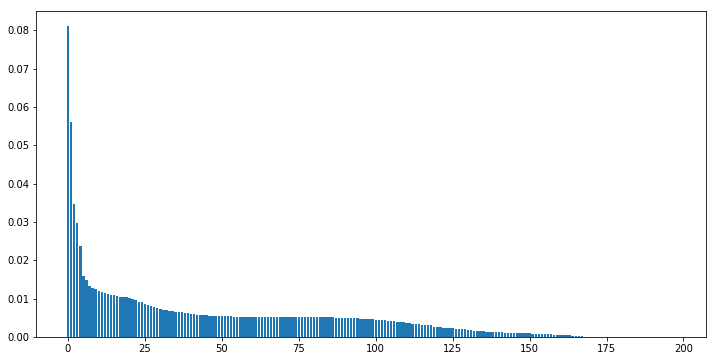

In [69]:
# Investigate the variance accounted for by each principal component.

p_comp =np.arange(len(azdias_pca.explained_variance_ratio_))
var = azdias_pca.explained_variance_ratio_

plt.figure(figsize=(12, 6))
plt.bar(p_comp, var)
plt.show()

In [70]:
# Re-apply PCA to the data while selecting for number of components to retain.

# Here we have number of components similar to the size of the original dataframe and except for the few first components it seems that 
# the variance ratio is more or less constant at around 50

# I want to select number of components that explains 80% of the data
azdias_pca.explained_variance_ratio_[:85].sum()

0.7963760431081361

In [67]:
# Perform PCA with 85 components
from sklearn.decomposition import PCA
pca = PCA(n_components=85).fit(azdias_scaled)
azdias_pca = pca.transform(azdias_scaled)

In [68]:
azdias_pca.shape

(798021, 85)

### Discussion 2.2: Perform Dimensionality Reduction

I retained 85 principal components because they conatin around 80% of the variance contained in the original 198 features. To note that the first 4 componenst contained around 20% of the data and the varianced droped dramatically as visible by the bar plot above.
If you multiply the PCA components by 5 to 20, you can only double the variance covered to 40% and to reach 80%, I had to get 85 components.

### Step 2.3: Interpret Principal Components

Now that we have our transformed principal components, it's a nice idea to check out the weight of each variable on the first few components to see if they can be interpreted in some fashion.

As a reminder, each principal component is a unit vector that points in the direction of highest variance (after accounting for the variance captured by earlier principal components). The further a weight is from zero, the more the principal component is in the direction of the corresponding feature. If two features have large weights of the same sign (both positive or both negative), then increases in one tend expect to be associated with increases in the other. To contrast, features with different signs can be expected to show a negative correlation: increases in one variable should result in a decrease in the other.

- To investigate the features, you should map each weight to their corresponding feature name, then sort the features according to weight. The most interesting features for each principal component, then, will be those at the beginning and end of the sorted list. Use the data dictionary document to help you understand these most prominent features, their relationships, and what a positive or negative value on the principal component might indicate.
- You should investigate and interpret feature associations from the first three principal components in this substep. To help facilitate this, you should write a function that you can call at any time to print the sorted list of feature weights, for the *i*-th principal component. This might come in handy in the next step of the project, when you interpret the tendencies of the discovered clusters.

In [69]:
def PC_W(df, n_comp):
    return pd.DataFrame(pca.components_[n_comp],index=df.columns, columns=['PC-'+str(n_comp+1)]).\
sort_values('PC-'+str(n_comp+1),ascending=False)

In [70]:
# Map weights for the first principal component to corresponding feature names
# and then print the linked values, sorted by weight.
# HINT: Try defining a function here or in a new cell that you can reuse in the
# other cells.

PC_W(azdias_scaled, 0).head()

,PC-1
LP_STATUS_GROB_1.0,0.189667
HH_EINKOMMEN_SCORE,0.180032
wealth,0.178395
PLZ8_ANTG3,0.178257
PLZ8_ANTG4,0.172780


In [71]:
PC_W(azdias_scaled, 0).tail()

,PC-1
KBA05_ANTG1,-0.174944
KBA05_GBZ,-0.176121
PLZ8_ANTG1,-0.179471
FINANZ_MINIMALIST,-0.182155
MOBI_REGIO,-0.182525


In [72]:
# Map weights for the second principal component to corresponding feature names
# and then print the linked values, sorted by weight.

PC_W(azdias_scaled, 1).head()

,PC-2
ALTERSKATEGORIE_GROB,0.236414
FINANZ_VORSORGER,0.222344
ZABEOTYP_3.0,0.199464
SEMIO_ERL,0.180876
SEMIO_LUST,0.164973


In [73]:
PC_W(azdias_scaled, 1).tail()

,PC-2
SEMIO_TRADV,-0.209749
FINANZ_UNAUFFAELLIGER,-0.216889
SEMIO_REL,-0.217934
FINANZ_SPARER,-0.232815
decade,-0.234148


In [74]:
# Map weights for the third principal component to corresponding feature names
# and then print the linked values, sorted by weight.

PC_W(azdias_scaled, 2).head()

,PC-3
SEMIO_VERT,0.313396
SEMIO_FAM,0.254421
SEMIO_SOZ,0.253661
SEMIO_KULT,0.246174
FINANZTYP_5.0,0.137976


In [75]:
PC_W(azdias_scaled, 2).tail()

,PC-3
SEMIO_ERL,-0.205174
SEMIO_KRIT,-0.264484
SEMIO_DOM,-0.272886
SEMIO_KAEM,-0.305097
ANREDE_KZ,-0.337173


### Discussion 2.3: Interpret Principal Components

PC-1: The first component is explained the most by LP_STATUS_GROB_1.0 and HH_EINKOMMEN_SCORE by almost equal weights, going back to the dictionary, LP_STATUS_GROB_1.0 are the low income earners while HH_EINKOMMEN_SCORE is the Estimated household net income and looking at the third in weight, the feature is wealth. Knowing this, we can see that this principle component is a summary of wealth and income of people.
On the other hand, the lowest festures in weight is MOBI_REGIO which is movement pattern and has nothing to do with the financial well being of customer.

PC-2: The second component highest features are ALTERSKATEGORIE_GROB, FINANZ_VORSORGER, ZABEOTYP_3.0 SEMIO_ERL . We can see less coherence among features of this group as we saw in the first component, as some related to age, while others related to financial typlogy where the people are more financially prepared and then we have fair supplied in energy consumption and event-oriented on the personality typology.
On the other hand, the lowest feature is FINANZ_SPARER, SEMIO_REL, FINANZ_UNAUFFAELLIGER which are almost the same as the highest weight but on a different level, as these are money savers and religious people and inconspicuous in financial feature.
I think this is an awesome principle component because it is high and low on the same features but with different levels wich makes it great in clustering people in groups.


PC-3: This is a very interesting principle component and like PC-1, it is mainly contains the peronality traits as the first 4 variables are SEMIO_(VERT, FAM, SOZ, KULT) which are dreamful, family-minded, socially-minded, cultural-minded, which really talks about the people not correlated to who maybe are more aggressive and are dominant(SEMIO_DOM),  aggressive (combative attitude) and and critical (SEMIO_KRIT)

## Step 3: Clustering

### Step 3.1: Apply Clustering to General Population

You've assessed and cleaned the demographics data, then scaled and transformed them. Now, it's time to see how the data clusters in the principal components space. In this substep, you will apply k-means clustering to the dataset and use the average within-cluster distances from each point to their assigned cluster's centroid to decide on a number of clusters to keep.

- Use sklearn's [KMeans](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html#sklearn.cluster.KMeans) class to perform k-means clustering on the PCA-transformed data.
- Then, compute the average difference from each point to its assigned cluster's center. **Hint**: The KMeans object's `.score()` method might be useful here, but note that in sklearn, scores tend to be defined so that larger is better. Try applying it to a small, toy dataset, or use an internet search to help your understanding.
- Perform the above two steps for a number of different cluster counts. You can then see how the average distance decreases with an increasing number of clusters. However, each additional cluster provides a smaller net benefit. Use this fact to select a final number of clusters in which to group the data. **Warning**: because of the large size of the dataset, it can take a long time for the algorithm to resolve. The more clusters to fit, the longer the algorithm will take. You should test for cluster counts through at least 10 clusters to get the full picture, but you shouldn't need to test for a number of clusters above about 30.
- Once you've selected a final number of clusters to use, re-fit a KMeans instance to perform the clustering operation. Make sure that you also obtain the cluster assignments for the general demographics data, since you'll be using them in the final Step 3.3.

In [76]:
azdias_pca.shape

(798021, 85)

In [77]:
sub_azdias = azdias_pca[:50000]

In [78]:
sub_azdias.shape

(50000, 85)

In [99]:
# Over a number of different cluster counts...
from sklearn.cluster import KMeans

cluster_dict = {}

clusters = [2, 3, 5, 6, 8, 9, 10, 13, 15, 18]
    # run k-means clustering on the data and...
for cluster in clusters:
    kmeans = KMeans(n_clusters=cluster, random_state=0).fit(sub_azdias)
    
    # compute the average within-cluster distances.
    score = abs(kmeans.score(sub_azdias))
    cluster_dict[cluster] = score
    print(cluster, 'Cluster has a score of: ', score)

2 Cluster has a score of:  7135684.13994548
3 Cluster has a score of:  6853934.265682173
5 Cluster has a score of:  6516492.197509904
6 Cluster has a score of:  6418964.995279796
8 Cluster has a score of:  6257869.238491702
9 Cluster has a score of:  6181689.390176407
10 Cluster has a score of:  6131749.608349602
13 Cluster has a score of:  5964210.92778504
15 Cluster has a score of:  5881557.36079703
18 Cluster has a score of:  5779987.759340874


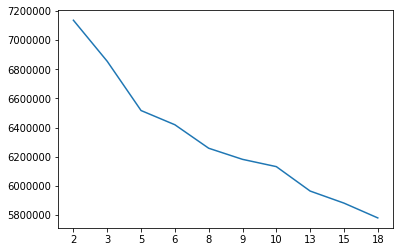

In [100]:
# Investigate the change in within-cluster distance across number of clusters.
# HINT: Use matplotlib's plot function to visualize this relationship.

plt.plot(range(len(cluster_dict)), list(cluster_dict.values()))
plt.xticks(range(len(cluster_dict)), list(cluster_dict.keys()))
plt.show()

In [80]:
# Re-fit the k-means model with the selected number of clusters and obtain
# cluster predictions for the general population demographics data.
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=8, random_state=0).fit(azdias_pca)
population_cluster = kmeans.predict(azdias_pca)

### Discussion 3.1: Apply Clustering to General Population

After choosing several sizes for the clusters, I decided to take 10 clusters because if we look at how the score was decreasing we notice that it was decreasing a decreasing rate, but at 8 clusters and beyond the rate diminishes and any additional number of clusters will be useless as the distances is barely decreasing.

### Step 3.2: Apply All Steps to the Customer Data

Now that you have clusters and cluster centers for the general population, it's time to see how the customer data maps on to those clusters. Take care to not confuse this for re-fitting all of the models to the customer data. Instead, you're going to use the fits from the general population to clean, transform, and cluster the customer data. In the last step of the project, you will interpret how the general population fits apply to the customer data.

- Don't forget when loading in the customers data, that it is semicolon (`;`) delimited.
- Apply the same feature wrangling, selection, and engineering steps to the customer demographics using the `clean_data()` function you created earlier. (You can assume that the customer demographics data has similar meaning behind missing data patterns as the general demographics data.)
- Use the sklearn objects from the general demographics data, and apply their transformations to the customers data. That is, you should not be using a `.fit()` or `.fit_transform()` method to re-fit the old objects, nor should you be creating new sklearn objects! Carry the data through the feature scaling, PCA, and clustering steps, obtaining cluster assignments for all of the data in the customer demographics data.

In [81]:
# Load in the customer demographics data.
customers = pd.read_csv('Data/P3/Udacity_CUSTOMERS_Subset.csv', delimiter=';')

In [82]:
customers.head()

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,2,4,1,5.0,5,1,5,1,2,2,...,3.0,3.0,1.0,0.0,1.0,5.0,5.0,1.0,2.0,1.0
1,-1,4,1,NaN,5,1,5,1,3,2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,-1,4,2,2.0,5,1,5,1,4,4,...,2.0,3.0,3.0,1.0,3.0,3.0,2.0,3.0,5.0,3.0
3,1,4,1,2.0,5,1,5,2,1,2,...,3.0,2.0,1.0,0.0,1.0,3.0,4.0,1.0,3.0,1.0
4,-1,3,1,6.0,3,1,4,4,5,2,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,3.0,5.0,1.0


In [83]:
# Apply preprocessing, feature transformation, and clustering from the general
# demographics onto the customer data, obtaining cluster predictions for the
# customer demographics data.

# Preprocessing using the clean_data() function
customers_df = clean_data(customers)

# Feature transformation
# Impute missing values
for col in customers_df.columns:
    if customers_df[col].isnull().sum() != 0:
        fill_value = customers_df[col].value_counts().sort_values(ascending=False).index[0]
        customers_df[col].fillna(fill_value, inplace=True)  

C:\Users\wfahme\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\wfahme\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [84]:
# There seems to be a difference of one column betwene two dataframes which prevented the transformtion
missing = []
for i in azdias_scaled.columns:
    if i not in customers_df.columns:
        missing.append(i)
missing  

['GEBAEUDETYP_5.0']

In [85]:
customers_df['GEBAEUDETYP_5.0'] = 0

In [86]:
customers_df.shape, azdias_scaled.shape

((141719, 198), (798021, 198))

In [87]:
# Scale the customer dataframe
scaled_df  = scaler.transform(customers_df)
customers_scaled = pd.DataFrame(scaled_df, columns=customers_df.columns)

# PCA Transform
customer_pca = pca.transform(customers_scaled)

In [88]:
# Cluster the customer dataframe
customer_cluster = kmeans.predict(customer_pca)

### Step 3.3: Compare Customer Data to Demographics Data

At this point, you have clustered data based on demographics of the general population of Germany, and seen how the customer data for a mail-order sales company maps onto those demographic clusters. In this final substep, you will compare the two cluster distributions to see where the strongest customer base for the company is.

Consider the proportion of persons in each cluster for the general population, and the proportions for the customers. If we think the company's customer base to be universal, then the cluster assignment proportions should be fairly similar between the two. If there are only particular segments of the population that are interested in the company's products, then we should see a mismatch from one to the other. If there is a higher proportion of persons in a cluster for the customer data compared to the general population (e.g. 5% of persons are assigned to a cluster for the general population, but 15% of the customer data is closest to that cluster's centroid) then that suggests the people in that cluster to be a target audience for the company. On the other hand, the proportion of the data in a cluster being larger in the general population than the customer data (e.g. only 2% of customers closest to a population centroid that captures 6% of the data) suggests that group of persons to be outside of the target demographics.

Take a look at the following points in this step:

- Compute the proportion of data points in each cluster for the general population and the customer data. Visualizations will be useful here: both for the individual dataset proportions, but also to visualize the ratios in cluster representation between groups. Seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) or [`barplot()`](https://seaborn.pydata.org/generated/seaborn.barplot.html) function could be handy.
  - Recall the analysis you performed in step 1.1.3 of the project, where you separated out certain data points from the dataset if they had more than a specified threshold of missing values. If you found that this group was qualitatively different from the main bulk of the data, you should treat this as an additional data cluster in this analysis. Make sure that you account for the number of data points in this subset, for both the general population and customer datasets, when making your computations!
- Which cluster or clusters are overrepresented in the customer dataset compared to the general population? Select at least one such cluster and infer what kind of people might be represented by that cluster. Use the principal component interpretations from step 2.3 or look at additional components to help you make this inference. Alternatively, you can use the `.inverse_transform()` method of the PCA and StandardScaler objects to transform centroids back to the original data space and interpret the retrieved values directly.
- Perform a similar investigation for the underrepresented clusters. Which cluster or clusters are underrepresented in the customer dataset compared to the general population, and what kinds of people are typified by these clusters?

In [89]:
# Compare the proportion of data in each cluster for the customer data to the
# proportion of data in each cluster for the general population.

cust_map = pd.DataFrame()
cust_map['data_index'] = customers_df.index.values
cust_map['cluster'] = customer_cluster+1

In [90]:
pop_map = pd.DataFrame()
pop_map['data_index'] = azdias_scaled.index.values
pop_map['cluster'] = population_cluster+1

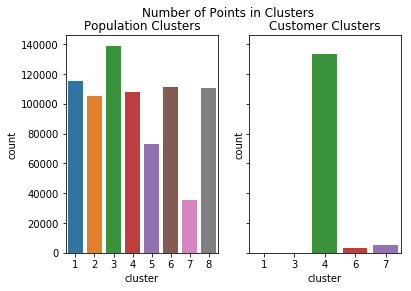

In [91]:
fig, (ax1, ax2) = plt.subplots(1,2, sharey=True)
fig.suptitle("Number of Points in Clusters")
ax1.title.set_text('Population Clusters')
ax2.title.set_text('Customer Clusters')
sns.countplot(pop_map.cluster, ax=ax1)
sns.countplot(cust_map.cluster, ax=ax2)
plt.show()

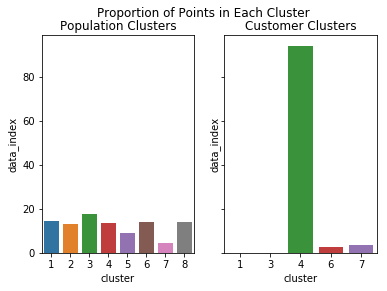

In [92]:
fig, (ax1, ax2) = plt.subplots(1,2, sharey=True)
fig.suptitle("Proportion of Points in Each Cluster")
ax1.title.set_text('Population Clusters')
ax2.title.set_text('Customer Clusters')
sns.barplot(x='cluster', y='data_index', data=pop_map, estimator=lambda x: len(x) / len(pop_map) * 100, ax=ax1)
sns.barplot(x='cluster', y='data_index', data=cust_map, estimator=lambda x: len(x) / len(cust_map) * 100, ax=ax2)
plt.show()

In [93]:
# Transforming cluster 6 back to its original values in the population dataframe with low nulls
overrepresented = list(pca.inverse_transform(kmeans.cluster_centers_[5]))
over_map = pd.DataFrame()
over_map['features'] = azdias_scaled.columns
over_map['Values'] = overrepresented
over_map.sort_values('Values', ascending=False).head()

,features,Values
108,LP_STATUS_FEIN_5.0,1.017327
6,FINANZ_UNAUFFAELLIGER,0.995373
5,FINANZ_ANLEGER,0.942468
194,decade,0.920248
115,LP_STATUS_GROB_2.0,0.864349


In [94]:
# What kinds of people are part of a cluster that is underrepresented in the
# customer data compared to the general population?
underpresented = list(pca.inverse_transform(kmeans.cluster_centers_[0]))
under_map = pd.DataFrame()
under_map['features'] = azdias_scaled.columns
under_map['Values'] = underpresented
under_map.sort_values('Values', ascending=False).head()

,features,Values
19,SEMIO_ERL,1.033735
128,ZABEOTYP_3.0,0.939462
24,SEMIO_KAEM,0.908624
1,ANREDE_KZ,0.867779
22,SEMIO_KRIT,0.807811


### Discussion 3.3: Compare Customer Data to Demographics Data

Overrepresented Cluster 6: This cluster is high on LP_STATUS_GROB_5.0 which are top earners, LP_STATUS_FEIN_10.0 also top earners, GREEN_AVANTGARDE enviromentally aware persons. This cluster represents a high income people who are highly interested in enviromental activities compared to the normal population. This group will be good target for marketing of high end products.

Overrepresented Cluster 1: This cluster is high on FINANZ_ANLEGER which is in financial typology is an investor, SEMIO_RAT Personality typology is a rational person, LP_STATUS_GROB_2.0 which are financially average earners. So this cluster is not represented in the popluation because these are average earning investors who are rational which is a small part of the population. In terms of marketing, this is a group that is not evern worth the marketing cost of a campaign.